<a href="https://colab.research.google.com/github/ryohei98/NK_model_Wall_2018/blob/main/Graduation_Paper_final_ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Driveをマウントする

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
!ls drive

MyDrive


##適応度地形の生成

In [ ]:
# -*- coding: utf-8 -*-
'''
Created on Wed Jun 13 15:42:13 2018
Updated on Tue May 21 08:49:00 2019
@author: Maciej Workiewicz
The code has been tested on Python 2.7 and 3.6 and higher
'''

print('''
----------------------------------------------------
Running Module 1: NK landscape creation and analysis
----------------------------------------------------
''')

# COMMENTS

# =============================================================================
# This code generates NK landscapes for a specific interaction matrix (IM) and 
# number of interactions between the decision variables (K). It has been created
# for NK landscapes with N=6, but it can be adapted to for other values of N.
# You can choose the type of an interaction matrix by setting variable
# 'which_imatrix' to:
#     1 - for a random interaction matrix (IM)
#     2 - for a modular (block-diagonal) IM
#     3 - for a nearly modular IM
#     4 - for a diagonal IM
#     5 - highly influential IM (Baumann & Siggelkow 2013)
#     6 - highly dependent IM (Baumann & Siggelkow 2013)
#     7 - Local IM (Rivkin and Siggelkow, 2007)
# 
# For the random IM the user can also set K from 0 to N-1 to tune the number of
# interactions.
# =============================================================================


# *** IMPORTED PACKAGES ***
import numpy as np
import itertools
import os # new
from time import time
import matplotlib.pyplot as plt
import random


start = time()  # starts the clock used to measure the execution speed

# *** MODEL INPUTS ****************************************************

# NK landscape parameters -----------------------------------------
N = 6  # number of detailed decisions per lower level landscape   |
i = 1000  # we will generate 1000 NK landscapes to begin with     |
# -----------------------------------------------------------------

# You can change the following variables:
which_imatrix = 1  # defines the type of an interaction matrix
                   # choose 1 for random, 2 for modular, 3 for nearly modular,
                   # 4 for diagonal, 5 for highly influential, and
                   # 6 for highly dependent, 7 local (see below)
K = 5  # only has an effect when you choose the random interaction matrix (1)
       # set to 2 for other interaction matrices

file_specific = '_t_100_ver_' #ファイルにつける特異的な名前


# *** GENERATING INTERACTION MATRICES ***************************************

def imatrix_rand(D,K):
    '''
    グループ分け可能
    ・部門数＝D
    ・グループに含まれる要素数＝P（以下に定義）
    '''
    P = N/D
    #zeros()_縦N個横N個の配列を全要素０の状態で生成
    Int_matrix_rand = np.zeros((N, N))

    #arrange(start,stop,kousa,dtype)_0~NでPの公差を持つ等差数列を配列の形で生成
    for aa1 in np.arange(0,N,P,dtype = int):
      Ln = aa1 + P
      for aa2 in np.arange(aa1,Ln,1,dtype = int):

        #range(N)_0~Nの連番を配列で生成する
        Indexes_1 = list(range(N))
        for i in np.arange(aa1,Ln,1,dtype = int):

          #remove(i)_同じ値を検索し、最初の要素を削除する
          Indexes_1.remove(i)  # remove selves

        #numpy.random.shuffle()_配列の要素をシャッフルする（in-place)  
        np.random.shuffle(Indexes_1)
        for i in np.arange(aa1,Ln,1,dtype = int):
          #append()_配列に新しい要素を追加する
          Indexes_1.append(i)

          #[-(K+1):最後]という意味
        Chosen_ones = Indexes_1[-(K+1):]  # this takes the last K+1 indexes
        for aa3 in Chosen_ones:
          Int_matrix_rand[aa2, aa3] = 1  # we turn on the interactions with K other variables
    return(Int_matrix_rand)



#==============================================================================
# Below are the other three types of interaction matrices.
# You can edit those if you want to check other petterns of interactions.
#==============================================================================

if which_imatrix == 2:  # MODULAR
    K = 2  # set to the average value
    Int_matrix = \
        np.array([
                 [1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0],
                 [0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1]
                 ])

elif which_imatrix == 3:  # NEARLY MODULAR
    K = 2  # set to the average value
    Int_matrix = \
        np.array([
                 [1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0],
                 [1, 0, 1, 1, 0, 0],
                 [0, 0, 1, 1, 0, 1],
                 [0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1]
                 ])
elif which_imatrix == 4:  # DIAGONAL
    K = 2  # set to average value and updated code below to poke three random holes
    Int_matrix4 = \
        np.array([
                 [1, 0, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 1, 0, 0],
                 [1, 1, 1, 1, 1, 0],
                 [1, 1, 1, 1, 1, 1]
                 ])
    
elif which_imatrix == 5:  # HIGHLY INFLUENTIAL Baumann & Siggelkow 2013
    K = 2  # set to the average value
    Int_matrix = \
        np.array([
                 [1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0],
                 [1, 1, 0, 1, 0, 0],
                 [1, 1, 0, 0, 1, 0],
                 [1, 1, 0, 0, 0, 1]
                 ])

elif which_imatrix == 6:  # HIGHLY DEPENDENT Baumann & Siggelkow 2013
    K = 2  # set to the average value
    Int_matrix = \
        np.array([
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 1]
                 ])
elif which_imatrix == 7:  # LOCAL Rivkin and Siggelkow, 2007
    K = 2  # set to the average value
    Int_matrix = \
        np.array([
                 [1, 1, 0, 0, 0, 1],
                 [1, 1, 1, 0, 0, 0],
                 [0, 1, 1, 1, 0, 0],
                 [0, 0, 1, 1, 1, 0],
                 [0, 0, 0, 1, 1, 1],
                 [1, 0, 0, 0, 1, 1]
                 ])

# *** NK GENERATING FUNCTIONS ***********************************************
def calc_fit(NK_land_, inter_m, Current_position, Power_key_):
    '''
    Takes the landscape and a given combination and returns a vector of fitness
    values for the vector of the N decision variables.
    '''
    Fit_vector = np.zeros(N)
    for ad1 in np.arange(N):
        Fit_vector[ad1] = NK_land_[np.sum(Current_position * inter_m[ad1]
                                          * Power_key_), ad1]
    return(Fit_vector)


def comb_and_values(NK_land_, Power_key_, inter_m):
    '''
    Calculates values for all combinations on the landscape. The resulting
    array contains:
    - the first columns indexed from 0 to N-1 are for each of the combinations
    - columns indexed from N to 2*N-1 are for the fit value (vector) of those combinations
    - the column indexed 2N is for the total fit (average of the entire vector)
    - column indexed 2N+1 is a dummy, with 1 indicating a local peak
    - the last column is a dummy, with 1 indicating the global peak
    '''
    Comb_and_value = np.zeros((2**N, N*2+3))  # to capture the results
    c1 = 0  # starting counter for location
    for c2 in itertools.product(range(2), repeat=N):
        # this takes time so be carefull with landscapes of bigger size
        Combination1 = np.array(c2)  # taking each combination
        fit_1 = calc_fit(NK_land_, inter_m, Combination1, Power_key_)
        Comb_and_value[c1, :N] = Combination1  # combination and values
        Comb_and_value[c1, N:2*N] = fit_1
        Comb_and_value[c1, 2*N] = np.mean(fit_1)
        c1 = c1 + 1
    for c3 in np.arange(2**N):  # now let's see if it is a local peak
        loc_p = 1  # first, assume it is
        for c4 in np.arange(N):  # check the local neighbourhood
            new_comb = Comb_and_value[c3, :N].copy().astype(int)
            new_comb[c4] = abs(new_comb[c4] - 1)
            if ((Comb_and_value[c3, 2*N] <
                 Comb_and_value[np.sum(new_comb*Power_key_), 2*N])):
                loc_p = 0  # if smaller than the neighbour, then it is not peak
        Comb_and_value[c3, 2*N+1] = loc_p
    max_ind = np.argmax(Comb_and_value[:, 2*N])
    Comb_and_value[max_ind, 2*N+2] = 1
    return(Comb_and_value)


# *** GENERATING THE NK LANDSCAPES ******************************************
Power_key = np.power(2, np.arange(N - 1, -1, -1))  # used to find addresses on the landscape
Landscape_data = np.zeros((i, 2**N, N*2+3))  # we prepare an array to receive the data

for i_1 in np.arange(i):
    '''
    Now we create the landscapes
    '''
    if which_imatrix==1:
        Int_matrix = imatrix_rand().astype(int)
    elif which_imatrix==4:  # diagonal
        '''
        The code below serves to poke three holes in the diagonal IM so that
        K=2. It is a little bit cumbersome but does the job  :-)
        Note that it only works with N=6
        '''
        Int_matrix = Int_matrix4.copy()
        id_change = random.sample(range(15), 3)
        for index in id_change:
            if index == 0:
                Int_matrix[1,0] = 0
            elif index == 1:
                Int_matrix[2,0] = 0
            elif index == 2:
                Int_matrix[2,1] = 0
            elif index == 3:
                Int_matrix[3,0] = 0
            elif index == 4:
                Int_matrix[3,1] = 0
            elif index == 5:
                Int_matrix[3,2] = 0
            elif index == 6:
                Int_matrix[4,0] = 0
            elif index == 7:
                Int_matrix[4,1] = 0
            elif index == 8:
                Int_matrix[4,2] = 0
            elif index == 9:
                Int_matrix[4,3] = 0
            elif index == 10:
                Int_matrix[5,0] = 0
            elif index == 11:
                Int_matrix[5,1] = 0
            elif index == 12:
                Int_matrix[5,2] = 0
            elif index == 13:
                Int_matrix[5,3] = 0
            elif index == 14:
                Int_matrix[5,4] = 0
    
    NK_land = np.random.rand(2**N, N)  # this is a table of random U(0,1) numbers
    # Now it is time to survey the topography of our NK landscape
    Landscape_data[i_1] = comb_and_values(NK_land, Power_key, Int_matrix)


# *** CALCULATING SUMMARY STATISTICS ****************************************
number_of_peaks = np.zeros(i)
max_values = np.zeros(i)
min_values = np.zeros(i)

for i_2 in np.arange(i):
    number_of_peaks[i_2] = np.sum(Landscape_data[i_2, :, 2*N+1])
    max_values[i_2] = np.max(Landscape_data[i_2, :, 2*N])
    min_values[i_2] = np.min(Landscape_data[i_2, :, 2*N])

# Let's print some summary statistics of our sample of NK landscapes
print('Summary statistics for IMatrix: ' + str(which_imatrix) + ' K=' + str(K))
print('average number of peaks: ' + str(np.mean(number_of_peaks)))
print('maximum number of peaks: ' + str(np.max(number_of_peaks)))
print('minimum number of peaks: ' + str(np.min(number_of_peaks)))
print('average maximum value: ' + str(np.mean(max_values)))
print('average minimum value: ' + str(np.mean(min_values)))

# plot histogram of the number of local peaks in our sample
plt.figure(1, facecolor='white', figsize=(8, 6), dpi=150)  # for screens with
#          higher resolution change dpi to 150 or 200. For normal use 75.
plt.hist(number_of_peaks, bins=20, range=(1, 20), color='dodgerblue', edgecolor='black') # adjust if necessary
plt.title('Distribution of the number of peaks', size=12)
plt.xlabel('number of peaks', size=10)
plt.ylabel('frequency', size=10)


# *** SAVING THE LANDSCAPES AS A BINARY FILE FOR FUTURE RETRIEVAL ************

#==============================================================================
# If you are saving files on a Mac, change the double back-slash \\ into a 
# single slash /
#==============================================================================

file_name = os.path.expanduser('~')  # we will save it in your home folder
if not os.path.exists(file_name + '\\NK_workshop\\'):
    os.makedirs(file_name + '\\NK_workshop\\')
np.save(file_name + '\\NK_workshop\\NK_land_type_' + str(which_imatrix) +
        '_K_' + str(K) + '_i_' + str(i) + '_' + str(file_specific) + '.npy', Landscape_data)

elapsed_time = time() - start
print('time: ' + str('%.2f' % elapsed_time) + ' sec')

# END OF LINE

##強化学習を追加してクラス化したモデル(Wall, 2018)

###クラスの読み込み

In [ ]:

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import copy
import random


class Var_set:
  def __init__(self, N, K, Mt, coord, T_star = 20, lamb = 0.2, b = 0.5, sigma_r = 0.1, sigma_head = 0.15):
    #意思決定の数
    self.N = int(N)
    #相互依存レベル
    self.K = int(K)
    #組織（Agent)の部門分け
    self.Mt = int(Mt)

    self.set_Nt()

    #グループ間の相互関係
    #0 = decentralized, 1= sequential, 2= proposal
    self.coord = int(coord)

    self. T_star = T_star
    self.lamb = lamb
    self.b = b
    self.sigma_r = sigma_r
    self.sigma_head = sigma_head

    #プロパティを名前と中に入っているものを表示
    for key, value in self.__dict__.items():
     print(key, ':', value)

  #一部門ごとに割り当てられている意思決定数を返す関数
  def set_Nt(self):
    #一部門の意思決定数
    self.Nt = int(self.N / self.Mt)

class Environment:
  def __init__(self, N, landscape):
    #何枚目の適応度地形を使用するか
    self.i = 0
    #意思決定の個数
    self.N = N
    #上でつくった適応度地形
    self.landscape = landscape
    #2進数→10進数の変換用配列
    self.converter = np.power(2, np.arange(N-1, -1, -1))
    #適応度地形ごとの最高点・最低点を入れておく
    self.reset()
    #プロパティを名前と中に入っているものを表示
    # for key, value in self.__dict__.items():
    #  print(key, ':', value)
        
  def reset(self):
    self.max_fit = np.max(self.landscape[self.i-1, :, 2*self.N])
    self.min_fit = np.min(self.landscape[self.i-1, :, 2*self.N])
    # self.max_fit=1
    # self.min_fit=0

  def step(self):
    self.i += 1
    self.reset()

  def get_contr_norm(self, decimal):
    return (self.landscape[self.i, decimal, 2*self.N] - self.min_fit) / (self.max_fit - self.min_fit)

  def get_norm_from_comb(self, comb):
    decimal = np.sum(comb * self.converter)
    norm = self.get_contr_norm(int(decimal))
    # print('norm:' +str(norm) )
    return norm

  def get_future_norm_from_comb(self, sigma, comb):
    norm = self.get_norm_from_comb(comb)
    norm += np.random.normal(0,sigma)
    return norm

class Agent:
  def __init__(self, var_set, environment):
    self.var_set = var_set
    self.environment = environment
    self.comb = np.random.binomial(1, 0.5, var_set.N)
    self.contr_norm = self.environment.get_norm_from_comb(self.comb)
    self.rec_norm = [0]
    self.rec_norm[0] = self.contr_norm 

    #プロパティを名前と中に入っているものを表示
    for key, value in self.__dict__.items():
     print(key, ':', value)

  def local_search(self):
    Nt = self.var_set.Nt
    Mt = self. var_set.Mt
    sigma_r = self.var_set.sigma_head
    sigma_head = self.var_set.sigma_head
    self.var_set.set_Nt()

    if self.var_set.coord == 2: 
      row = 0
      rec_comb = np.zeros((3, self.var_set.N))

    for a1 in range(Mt):
      comb_alpha = copy.copy(self.comb)
      comb_beta = copy.copy(self.comb)
      comb_current = copy.copy(self.comb)
      comb_new = copy.copy(self.comb)

      # print('self.comb:' + str(self.comb))

      change_keys = random.sample(range(Nt),2)

      change_key1 = change_keys[0]
      change_key2 = change_keys[1]
      # print('change_key1:' + str(change_key1))
      # print('change_key2:' + str(change_key2))
      # print('a1:' + str(a1))
      # print('Nt:'+str(Nt))
      change_key1 += a1 * Nt
      change_key2 += a1 * Nt
      # print('change_key1:' + str(change_key1))
      # print('change_key2:' + str(change_key2))

      comb_alpha[change_key1] = abs(comb_alpha[change_key1] -1)
      comb_beta[change_key2] = abs(comb_alpha[change_key2] -1)

      # print('comb_alpha:' + str(comb_alpha))
      # print('comb_beta_:' + str(comb_beta))
      # print('self.comb_:' + str(self.comb))

      contr_alpha = self.environment.get_future_norm_from_comb(sigma_r, comb_alpha)
      contr_beta = self.environment.get_future_norm_from_comb(sigma_r, comb_beta)

      # print('contr_alpha:' + str(contr_alpha))
      # print('contr_beta:' + str(contr_beta))
      # print('self.contr_norm:' + str(self.contr_norm))
      if self.var_set.coord == 0:
        if contr_alpha > self.contr_norm and contr_alpha > contr_beta:
          comb_new[a1*Nt:a1*Nt+Nt] = comb_alpha[a1*Nt:a1*Nt+Nt]
        elif contr_beta > self.contr_norm and contr_beta > contr_alpha:
          comb_new[a1*Nt:a1*Nt+Nt] = comb_beta[a1*Nt:a1*Nt+Nt]
      
      elif self.var_set.coord == 1:
        if contr_alpha > self.contr_norm and contr_alpha > contr_beta:
          self.comb[a1*Nt:a1*Nt+Nt] = comb_alpha[a1*Nt:a1*Nt+Nt]
        elif contr_beta > self.contr_norm and contr_beta > contr_alpha:
          self.comb[a1*Nt:a1*Nt+Nt] = comb_beta[a1*Nt:a1*Nt+Nt]

      else:
        if contr_alpha > self.contr_norm and contr_alpha > contr_beta:
          rec_comb[0][a1*Nt:a1*Nt+Nt] = comb_alpha[a1*Nt:a1*Nt+Nt]
          if contr_beta > self.contr_norm:
            rec_comb[1][a1*Nt:a1*Nt+Nt] = comb_beta[a1*Nt:a1*Nt+Nt]
            rec_comb[2][a1*Nt:a1*Nt+Nt] = copy.copy(self.comb[a1*Nt:a1*Nt+Nt])
          else: 
            rec_comb[1][a1*Nt:a1*Nt+Nt] = copy.copy(self.comb[a1*Nt:a1*Nt+Nt])
            rec_comb[2][a1*Nt:a1*Nt+Nt] = comb_beta[a1*Nt:a1*Nt+Nt]

        elif contr_beta > self.contr_norm and contr_beta > contr_alpha:
          rec_comb[0][a1*Nt:a1*Nt+Nt] = comb_beta[a1*Nt:a1*Nt+Nt]
          if contr_alpha > self.contr_norm:
            rec_comb[1][a1*Nt:a1*Nt+Nt] = comb_alpha[a1*Nt:a1*Nt+Nt]
            rec_comb[2][a1*Nt:a1*Nt+Nt] = copy.copy(self.comb[a1*Nt:a1*Nt+Nt])
          else: 
            rec_comb[1][a1*Nt:a1*Nt+Nt] = copy.copy(self.comb[a1*Nt:a1*Nt+Nt])
            rec_comb[2][a1*Nt:a1*Nt+Nt] = comb_alpha[a1*Nt:a1*Nt+Nt]

        else:
          rec_comb[0][a1*Nt:a1*Nt+Nt] = copy.copy(self.comb[a1*Nt:a1*Nt+Nt])
          if contr_alpha > contr_beta:
            rec_comb[1][a1*Nt:a1*Nt+Nt] = comb_alpha[a1*Nt:a1*Nt+Nt]
            rec_comb[2][a1*Nt:a1*Nt+Nt] = comb_beta[a1*Nt:a1*Nt+Nt]
          else: 
            rec_comb[1][a1*Nt:a1*Nt+Nt] =  comb_beta[a1*Nt:a1*Nt+Nt]
            rec_comb[2][a1*Nt:a1*Nt+Nt] =  comb_alpha[a1*Nt:a1*Nt+Nt]
    
      # print('----------'+str(a1*Nt))
      # print('rec_comb:'+str(rec_comb))

    if self.var_set.coord == 2:
      contr_first = self.environment.get_future_norm_from_comb(self.var_set.sigma_head, rec_comb[0])
      contr_second = self.environment.get_future_norm_from_comb(self.var_set.sigma_head, rec_comb[1])
      # print('contr_first:' + str(contr_first))
      # print('contr_second:' + str(contr_second))
      # print('self.contr_norm:' + str(self.contr_norm))

      if contr_first > contr_second and contr_first > self.contr_norm :
        comb_new = rec_comb[0]
      elif contr_second > self.contr_norm:
        comb_new = rec_comb[1]
      else:
        comb_new = self.comb
    
    if self.var_set.coord != 1:
      self.comb = copy.copy(comb_new)
    

    self.contr_norm = self.environment.get_norm_from_comb(self.comb)
    self.rec_norm.append(self.contr_norm)

class Manager:
  def __init__(self,var_set,agent):
    self.var_set = var_set
    self.b = self.var_set.b
    self.lamb = self.var_set.lamb
    self.T_star = self.var_set.T_star
    self.A = self.create_A()
    self.prob_feasibles = np.array(self.create_prob_feasibles())
    rec_probs_beta = np.zeros((1,len(self.A)))
    rec_probs_beta[0] = self.prob_feasibles
    self.rec_prob_feasibles = pd.DataFrame(rec_probs_beta, columns = ['Mt=2','Mt=3','Mt=4','Mt=6']) 
    self.rec_average_norm = np.zeros(1)
    self.Nu_t = 0
    self.delta_Vt = 0
    self.agent = agent

    #プロパティを名前と中に入っているものを表示
    for key, value in self.__dict__.items():
     print(key, ':', value)  

  def create_A(self):
    N = self.var_set.N
    A = []
    for m1 in np.arange(N-2)+2:
      if N % m1 == 0:
        A.append(m1)

    print(A)
    return A

  def create_prob_feasibles(self):
    len_A = len(self.A)
    prob_feasibles_init = [0]*len_A
    for a_1 in np.arange(len_A):
      prob_feasibles_init[a_1] += 1 / len_A
    return prob_feasibles_init

  def select_Mt(self):
    if len(self.agent.rec_norm) > self.T_star*2:
      self.train()
      print('train()されました')
    self.var_set.Mt = np.random.choice(self.A, p = self.prob_feasibles)
    print(str(self.var_set.Mt)+'が選択されました')
    self.var_set.set_Nt()

  def train(self):
    pre_start_index = len(self.agent.rec_norm)- self.T_star*2 -1
    this_start_index = pre_start_index + self.T_star
    pre_performance = np.sum(self.agent.rec_norm[pre_start_index:this_start_index]) / self.T_star 
    this_performance = np.sum(self.agent.rec_norm[this_start_index:]) / self.T_star
    delta_Vt = (this_performance - pre_performance) / pre_performance
    print('delta_Vt:' + str(delta_Vt))
    self.Nu_t = self.b * self.delta_Vt + (1-self.b)*self.Nu_t
    print('Nu_t:'+str(self.Nu_t))
    self.delta_Vt = delta_Vt

    if self.Nu_t > delta_Vt:
      tau_t = False
    else :
      tau_t = True

    print('tau_t:' + str(tau_t))
    len_A = len(self.A)
    prob_feasibles = np.copy(self.prob_feasibles)
    new_probs = [0]*len_A

    Mt = self.var_set.Mt
    for aa in self.A:
      a_index = self.A.index(aa)
      print('A-index:'+str(a_index))
      if aa == self.var_set.Mt:
        if tau_t:
          new_probs[a_index] = prob_feasibles[a_index] + self.lamb *(1-prob_feasibles[a_index])
          print(str(Mt)+'が強化されました')
        else:
          new_probs[a_index] = prob_feasibles[a_index] - self.lamb * prob_feasibles[a_index]
          print(str(Mt)+ 'が逆強化されました')
      else:
        if tau_t:
          new_probs[a_index] = prob_feasibles[a_index] - self.lamb * prob_feasibles[a_index]
          print(str(aa)+ 'が強化されました')
        else:
          Mt_index = self.A.index(Mt)
          print('Mt_index:'+str(Mt_index))
          new_probs[a_index] = prob_feasibles[a_index] + self.lamb * ((prob_feasibles[a_index]*prob_feasibles[Mt_index])/(1-prob_feasibles[Mt_index]))
          print(str(aa)+'が逆強化されました')
      
      if new_probs[a_index] < 0.001:
        new_probs[a_index] = 0.001
    
    new_probs = new_probs / np.sum(new_probs)
    self.prob_feasibles = new_probs
    self.rec_prob_feasibles.loc[len(self.rec_prob_feasibles)] = new_probs


##実行ーmain



N : 12
K : 6
Mt : 3
Nt : 4
coord : 0
T_star : 20
lamb : 0.5
b : 0.5
sigma_r : 0.1
sigma_head : 0.15
var_set : <__main__.Var_set object at 0x7f84cc63aa58>
environment : <__main__.Environment object at 0x7f84cc63a588>
comb : [0 1 0 0 0 0 1 0 0 1 1 1]
contr_norm : 0.393947106000356
rec_norm : [0.393947106000356]
[2, 3, 4, 6]
var_set : <__main__.Var_set object at 0x7f84cc63aa58>
b : 0.5
lamb : 0.5
T_star : 20
A : [2, 3, 4, 6]
prob_feasibles : [0.25 0.25 0.25 0.25]
rec_prob_feasibles :    Mt=2  Mt=3  Mt=4  Mt=6
0  0.25  0.25  0.25  0.25
rec_average_norm : [0.]
Nu_t : 0.1
delta_Vt : 0
agent : <__main__.Agent object at 0x7f84cc8072b0>
select_Mt()されました
prob_feasibles:[0.25 0.25 0.25 0.25]
delta_Vt:0.8242306079695507
Nu_t:0.099875
tau_t:False
select_Mt()されました
prob_feasibles:[0.29166667 0.29166667 0.125      0.29166667]
delta_Vt:-0.39094152571890406
Nu_t:0.09975015625
tau_t:True
select_Mt()されました
prob_feasibles:[0.14583333 0.64583333 0.0625     0.14583333]
delta_Vt:0.5510615181211291
Nu_t:0.09962

<Figure size 432x288 with 0 Axes>

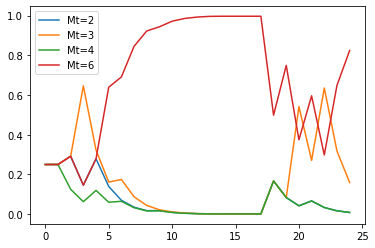

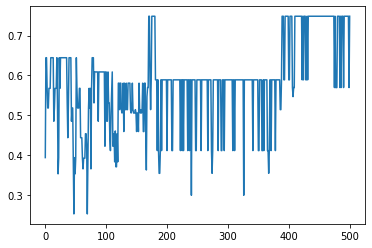

In [18]:
import matplotlib.pyplot as plt



file_specific = '_t_100_ver_' #ファイルにつける特異的な名前
file_name ='/content/drive/My Drive'
N = 12  #要素数
K = 6
G = 2
Mt = 3
I = 1000  # 期数
T = 500  #一期あたりの回数
coord = 0

NK_landscape = np.load(file_name + '/NK_workshop/NK_land_type_1' + '_D_' + str(G) + '_K_' + str(K) + '_i_' + str(I) + '.npy')
var_set = Var_set(N, K, Mt, coord) 
environment = Environment(12, NK_landscape)
agent = Agent(var_set, environment)
manager = Manager(var_set, agent)
for t1 in range(T):
  agent.local_search()
  if t1 % var_set.T_star == 0 and t1 != 0:
    manager.select_Mt()
    print('select_Mt()されました')
    print('prob_feasibles:'+str(manager.prob_feasibles))
print('rec_norm:' + str(agent.rec_norm))
print('rec_prob_feasibles:')
print(manager.rec_prob_feasibles)

plt.figure()
manager.rec_prob_feasibles.plot()
plt.legend()
plt.figure()
plt.plot(agent.rec_norm)

  


In [ ]:
import numpy as np
from os.path import expanduser  # new
import matplotlib.pyplot as plt
import csv
from google.colab import drive
import os
import random

N = 12  #要素数
K = 3
i = 1000  # 期数
t = 100   #一期あたりの回数
coord = 1
file_specific = '_t_100_ver_' #ファイルにつける特異的な名前
file_name ='/content/drive/My Drive'
save_folder_name = '/NK_workshop/Graduation_ver/'

KG_matrix = \
  np.array([
            [2,5,6,7],
            [3,3,4,5],
            [4,2,3,4],
            [6,1,2,3]
            ])
  
Mt_arr = [2,3,4,6]
counter = 1  
result  = [[''] * t +2 for i in range(48)]

for coord in range(3):

  for Mt in Mt_arr:

    for GG in [0,1,2,3]:

      plt.figure(facecolor='white', figsize=(8, 6), dpi=150)

      for KK in [1,2,3]:
        G = KG_matrix[GG,0]
        K = KG_matrix[GG,KK]
        Kex = K - int(N/G) +1

        print('G:'+ str(G))
        print('K:'+ str(K))
        print('Kex:'+ str(Kex)) 
        
        NK_landscape = np.load(file_name + '/NK_workshop/NK_land_type_1' + '_D_' + str(G) + '_K_' + str(K) + '_i_' + str(i) + '.npy')

        var_set = Var_set(N, K, Mt, coord) 
        environment = Environment(12, NK_landscape)
        agent = Agent(var_set, environment)
        rec_norm_all = np.zeros((i,t+1))

        for i1 in range(i):
          for t1 in range(t):
            agent.local_search()
          rec_norm_all[i1, 0:] = agent.rec_norm
          agent = Agent(var_set, environment)
          environment.step()
          

        rec_norm_all_average = []
        for t2 in range(t):
          rec_norm_all_average.append(np.sum(rec_norm_all[0:, t2]) / i)

        result[counter-1][0] = str('_G_' + str(G) + '_K_' + str(K) + '_i_' + str(i)+'_Mt_'+str(var_set.Mt) + '_coord_' + str(var_set.coord))
        result[counter-1][1:] = map(str,rec_norm_all_average)

        x = range(t)
        y = rec_norm_all_average

        label_str = str('G='+str(G) +', K='+ str(K)+ ', Kex=' +str(Kex))
        plt.plot(x,y, label = label_str)
      plt.ylim(0,1)
      if coord == 0:
        coord_str = 'decentralized'
      elif coord == 1:
        coord_str = 'sequential'
      elif coord == 2:
        coord_str = 'proposal'
      plt.title('Transition of normalized contribution ( Mt =' + str(var_set.Mt) + ', coord = ' + str(coord_str) + ')', size=12)
      plt.xlabel('Time Periods', size=12)
      plt.ylabel('Normalized contribution', size=12)
      plt.legend(loc=4,prop={'size':10})
      plt.legend(loc= 'best')
      if not os.path.exists(file_name + save_folder_name):
        os.makedirs(file_name + save_folder_name)
      plt.savefig(file_name + save_folder_name+ '_G_' + str(G) + '_K_' + str(K) + '_i_' + str(i)+'_Mt_'+str(var_set.Mt) + '_coord_' + str(var_set.coord) +str(file_specific)+'.jpg', format='jpg')
      print(str(counter) +  '周目が終わりました')
      counter += 1

      

G:2
K:5
Kex:0


ValueError: ignored

<Figure size 1200x900 with 0 Axes>

## Original Model


###クラスの読み込み

In [56]:

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import copy
import random


class Var_set:
  def __init__(self, N, K, Mt, coord, T_star = 20, lamb = 0.5, b = 0.5, sigma_r = 0.1, sigma_head = 0.15):
    #意思決定の数
    self.N = int(N)
    #相互依存レベル
    self.K = int(K)
    #組織（Agent)の部門分け
    self.Mt = int(Mt)

    self.set_Nt()

    #グループ間の相互関係
    #0 = decentralized, 1= sequential, 2= proposal
    self.coord = int(coord)

    self. T_star = T_star
    self.lamb = lamb
    self.b = b
    self.sigma_r = sigma_r
    self.sigma_head = sigma_head

    #プロパティを名前と中に入っているものを表示
    for key, value in self.__dict__.items():
     print(key, ':', value)

  #一部門ごとに割り当てられている意思決定数を返す関数
  def set_Nt(self):
    #一部門の意思決定数
    self.Nt = int(self.N / self.Mt)

class Environment:
  def __init__(self, N, landscape):
    #何枚目の適応度地形を使用するか
    self.i = 0
    #意思決定の個数
    self.N = N
    #上でつくった適応度地形
    self.landscape = landscape
    #2進数→10進数の変換用配列
    self.converter = np.power(2, np.arange(N-1, -1, -1))
    #適応度地形ごとの最高点・最低点を入れておく
    self.reset()
    #プロパティを名前と中に入っているものを表示
    # for key, value in self.__dict__.items():
    #  print(key, ':', value)
        
  def reset(self):
    self.max_fit = np.max(self.landscape[self.i, :, 2*self.N])
    self.min_fit = np.min(self.landscape[self.i, :, 2*self.N])
    # self.max_fit=1
    # self.min_fit=0

  def step(self):
    self.i += 1
    self.reset()

  def get_contr_norm(self, decimal):
    return (self.landscape[self.i, decimal, 2*self.N] - self.min_fit) / (self.max_fit - self.min_fit)

  def get_norm_from_comb(self, comb):
    decimal = np.sum(comb * self.converter)
    norm = self.get_contr_norm(int(decimal))
    # print('norm:' +str(norm) )
    return norm

  def get_future_norm_from_comb(self, sigma, comb):
    norm = self.get_norm_from_comb(comb)
    norm += np.random.normal(0,sigma)
    return norm

class Agent:
  def __init__(self, var_set, environment):
    self.var_set = var_set
    self.environment = environment
    self.comb = np.random.binomial(1, 0.5, var_set.N)
    self.contr_norm = self.environment.get_norm_from_comb(self.comb)
    self.rec_norm = [0]
    self.rec_norm[0] = self.contr_norm 

    #プロパティを名前と中に入っているものを表示
    for key, value in self.__dict__.items():
     print(key, ':', value)

  def local_search(self):
    Nt = self.var_set.Nt
    Mt = self. var_set.Mt
    sigma_r = self.var_set.sigma_head
    sigma_head = self.var_set.sigma_head
    self.var_set.set_Nt()

    if self.var_set.coord == 2: 
      row = 0
      rec_comb = np.zeros((3, self.var_set.N))

    for a1 in range(Mt):
      comb_alpha = copy.copy(self.comb)
      comb_beta = copy.copy(self.comb)
      comb_current = copy.copy(self.comb)
      comb_new = copy.copy(self.comb)

      # print('self.comb:' + str(self.comb))

      change_keys = random.sample(range(Nt),2)

      change_key1 = change_keys[0]
      change_key2 = change_keys[1]
      # print('change_key1:' + str(change_key1))
      # print('change_key2:' + str(change_key2))
      # print('a1:' + str(a1))
      # print('Nt:'+str(Nt))
      change_key1 += a1 * Nt
      change_key2 += a1 * Nt
      # print('change_key1:' + str(change_key1))
      # print('change_key2:' + str(change_key2))

      comb_alpha[change_key1] = abs(comb_alpha[change_key1] -1)
      comb_beta[change_key2] = abs(comb_alpha[change_key2] -1)

      # print('comb_alpha:' + str(comb_alpha))
      # print('comb_beta_:' + str(comb_beta))
      # print('self.comb_:' + str(self.comb))

      contr_alpha = self.environment.get_future_norm_from_comb(sigma_r, comb_alpha)
      contr_beta = self.environment.get_future_norm_from_comb(sigma_r, comb_beta)

      # print('contr_alpha:' + str(contr_alpha))
      # print('contr_beta:' + str(contr_beta))
      # print('self.contr_norm:' + str(self.contr_norm))
      if self.var_set.coord == 0:
        if contr_alpha > self.contr_norm and contr_alpha > contr_beta:
          comb_new[a1*Nt:a1*Nt+Nt] = comb_alpha[a1*Nt:a1*Nt+Nt]
        elif contr_beta > self.contr_norm and contr_beta > contr_alpha:
          comb_new[a1*Nt:a1*Nt+Nt] = comb_beta[a1*Nt:a1*Nt+Nt]
      
      elif self.var_set.coord == 1:
        if contr_alpha > self.contr_norm and contr_alpha > contr_beta:
          self.comb[a1*Nt:a1*Nt+Nt] = comb_alpha[a1*Nt:a1*Nt+Nt]
        elif contr_beta > self.contr_norm and contr_beta > contr_alpha:
          self.comb[a1*Nt:a1*Nt+Nt] = comb_beta[a1*Nt:a1*Nt+Nt]

      else:
        if contr_alpha > self.contr_norm and contr_alpha > contr_beta:
          rec_comb[0][a1*Nt:a1*Nt+Nt] = comb_alpha[a1*Nt:a1*Nt+Nt]
          if contr_beta > self.contr_norm:
            rec_comb[1][a1*Nt:a1*Nt+Nt] = comb_beta[a1*Nt:a1*Nt+Nt]
            rec_comb[2][a1*Nt:a1*Nt+Nt] = copy.copy(self.comb[a1*Nt:a1*Nt+Nt])
          else: 
            rec_comb[1][a1*Nt:a1*Nt+Nt] = copy.copy(self.comb[a1*Nt:a1*Nt+Nt])
            rec_comb[2][a1*Nt:a1*Nt+Nt] = comb_beta[a1*Nt:a1*Nt+Nt]

        elif contr_beta > self.contr_norm and contr_beta > contr_alpha:
          rec_comb[0][a1*Nt:a1*Nt+Nt] = comb_beta[a1*Nt:a1*Nt+Nt]
          if contr_alpha > self.contr_norm:
            rec_comb[1][a1*Nt:a1*Nt+Nt] = comb_alpha[a1*Nt:a1*Nt+Nt]
            rec_comb[2][a1*Nt:a1*Nt+Nt] = copy.copy(self.comb[a1*Nt:a1*Nt+Nt])
          else: 
            rec_comb[1][a1*Nt:a1*Nt+Nt] = copy.copy(self.comb[a1*Nt:a1*Nt+Nt])
            rec_comb[2][a1*Nt:a1*Nt+Nt] = comb_alpha[a1*Nt:a1*Nt+Nt]

        else:
          rec_comb[0][a1*Nt:a1*Nt+Nt] = copy.copy(self.comb[a1*Nt:a1*Nt+Nt])
          if contr_alpha > contr_beta:
            rec_comb[1][a1*Nt:a1*Nt+Nt] = comb_alpha[a1*Nt:a1*Nt+Nt]
            rec_comb[2][a1*Nt:a1*Nt+Nt] = comb_beta[a1*Nt:a1*Nt+Nt]
          else: 
            rec_comb[1][a1*Nt:a1*Nt+Nt] =  comb_beta[a1*Nt:a1*Nt+Nt]
            rec_comb[2][a1*Nt:a1*Nt+Nt] =  comb_alpha[a1*Nt:a1*Nt+Nt]
    
      # print('----------'+str(a1*Nt))
      # print('rec_comb:'+str(rec_comb))

    if self.var_set.coord == 2:
      contr_first = self.environment.get_future_norm_from_comb(self.var_set.sigma_head, rec_comb[0])
      contr_second = self.environment.get_future_norm_from_comb(self.var_set.sigma_head, rec_comb[1])
      # print('contr_first:' + str(contr_first))
      # print('contr_second:' + str(contr_second))
      # print('self.contr_norm:' + str(self.contr_norm))

      if contr_first > contr_second and contr_first > self.contr_norm :
        comb_new = rec_comb[0]
      elif contr_second > self.contr_norm:
        comb_new = rec_comb[1]
      else:
        comb_new = self.comb
    
    if self.var_set.coord != 1:
      self.comb = copy.copy(comb_new)
    

    self.contr_norm = self.environment.get_norm_from_comb(self.comb)
    self.rec_norm.append(self.contr_norm)

class Manager:
  def __init__(self,var_set,agent, aspiration_level = 0.8):
    self.var_set = var_set
    self.b = self.var_set.b
    self.lamb = self.var_set.lamb
    self.T_star = self.var_set.T_star
    self.A = self.create_A()
    self.prob_feasibles = np.array(self.create_prob_feasibles())
    rec_probs_beta = np.zeros((1,len(self.A)))
    rec_probs_beta[0] = self.prob_feasibles
    self.rec_prob_feasibles = pd.DataFrame(rec_probs_beta, columns = ['Mt=2','Mt=3','Mt=4','Mt=6']) 
    self.Nu_t = 0
    self.delta_Vt = 0
    self.agent = agent
    # self.aspiration_level = aspiration_level

    #プロパティを名前と中に入っているものを表示
    for key, value in self.__dict__.items():
     print(key, ':', value)  

  def create_A(self):
    N = self.var_set.N
    A = []
    for m1 in np.arange(N-2)+2:
      if N % m1 == 0:
        A.append(m1)

    print(A)
    return A

  def reset(self):
    self.prob_feasibles = np.array(self.create_prob_feasibles())
    rec_probs_beta = np.zeros((1,len(self.A)))
    rec_probs_beta[0] = self.prob_feasibles
    self.rec_prob_feasibles = pd.DataFrame(rec_probs_beta, columns = ['Mt=2','Mt=3','Mt=4','Mt=6']) 
    self.agent.comb = np.random.binomial(1,0.5,self.var_set.N)

  def create_prob_feasibles(self):
    len_A = len(self.A)
    prob_feasibles_init = [0]*len_A
    for a_1 in np.arange(len_A):
      prob_feasibles_init[a_1] += 1 / len_A
    return prob_feasibles_init

  def select_Mt(self):
    if len(self.agent.rec_norm) >= self.T_star*2:
      self.train()
      # print('train()されました')
    self.rec_prob_feasibles.loc[len(self.rec_prob_feasibles)] = self.prob_feasibles
    self.var_set.Mt = np.random.choice(self.A, p = self.prob_feasibles)
    # print(str(self.var_set.Mt)+'が選択されました')
    self.var_set.set_Nt()

  def train(self):
    # pre_performance = 0
    # this_performance = 0

    # for ttt in np.arange(self.T_star):
    #   pre_start_index = len(self.agent.rec_norm)- self.T_star*2 -1
    #   this_start_index = pre_start_index + self.T_star
    #   pre_performance += (self.agent.rec_norm[ttt + pre_start_index] - self.agent.rec_norm[ttt + pre_start_index-1]) / self.agent.rec_norm[ttt + pre_start_index-1] 
    #   this_performance += (self.agent.rec_norm[ttt + this_start_index] - self.agent.rec_norm[ttt + this_start_index - 1]) / self.agent.rec_norm[ttt + this_start_index-1]

    # pre_performance = pre_performance / self.T_star
    # this_performance = this_performance / self.T_star

    # print('pre_performance:' + str(pre_performance))
    # print('this_performance:' + str(this_performance))

    start_index = len(self.agent.rec_norm) - self.T_star -1
    end_index = start_index + self.T_star
    this_performance = self.agent.rec_norm[end_index]
    pre_performance = self.agent.rec_norm[start_index]
    delta_Vt = (this_performance - pre_performance) / pre_performance
    # delta_Vt = this_performance
    
    print('delta_Vt:' + str(delta_Vt))
    self.Nu_t = self.b * self.delta_Vt + (1-self.b)*self.Nu_t
    # self.Nu_t -= self.Nu_t / 800
    print('Nu_t:'+str(self.Nu_t))

    self.delta_Vt = delta_Vt

    if delta_Vt <= self.Nu_t :
      tau_t = True
    else :
      tau_t = False

    print('tau_t:' + str(tau_t))
    len_A = len(self.A)
    prob_feasibles = np.copy(self.prob_feasibles)
    new_probs = np.copy(prob_feasibles)
    # reinforce_value = this_performance - self.aspiration_level
    # self.aspiration_level += self.aspiration_level / 2000
    Mt = self.var_set.Mt
    Mt_index = self.A.index(Mt)
    for aa in self.A:
      a_index = self.A.index(aa)

    # #   if a_index == Mt_index:
    # new_probs[Mt_index] = prob_feasibles[Mt_index] + self.lamb* (reinforce_value)

      # # print('A-index:'+str(a_index))
      if aa == self.var_set.Mt:
        if tau_t:
          new_probs[a_index] = prob_feasibles[a_index] + self.lamb *(1-prob_feasibles[a_index])
          # print(str(Mt)+'が強化されました')
        else:
          new_probs[a_index] = prob_feasibles[a_index] - self.lamb * prob_feasibles[a_index]
          # print(str(Mt)+ 'が逆強化されました')
      else:
        if tau_t:
          new_probs[a_index] = prob_feasibles[a_index] - self.lamb * prob_feasibles[a_index]
          # print(str(aa)+ 'が強化されました')
        else:
          Mt_index = self.A.index(Mt)
          # print('Mt_index:'+str(Mt_index))
          new_probs[a_index] = prob_feasibles[a_index] + self.lamb * ((prob_feasibles[a_index]*prob_feasibles[Mt_index])/(1-prob_feasibles[Mt_index]))
          # print(str(aa)+'が逆強化されました')

    # for aa in self.A:
      # a_index = self.A.index(aa)  
      if new_probs[a_index] < 0.001:
        new_probs[a_index] = 0.001
    
    new_probs = new_probs / np.sum(new_probs)
    self.prob_feasibles = new_probs


###実行

N : 12
K : 2
Mt : 3
Nt : 4
coord : 1
T_star : 20
lamb : 0.5
b : 0.5
sigma_r : 0.05
sigma_head : 0.05
var_set : <__main__.Var_set object at 0x7f84c44fb2b0>
environment : <__main__.Environment object at 0x7f84c3e05470>
comb : [1 1 1 0 0 1 0 0 0 0 0 1]
contr_norm : 0.8519352479377332
rec_norm : [0.8519352479377332]
[2, 3, 4, 6]
var_set : <__main__.Var_set object at 0x7f84c44fb2b0>
b : 0.5
lamb : 0.5
T_star : 20
A : [2, 3, 4, 6]
prob_feasibles : [0.25 0.25 0.25 0.25]
rec_prob_feasibles :    Mt=2  Mt=3  Mt=4  Mt=6
0  0.25  0.25  0.25  0.25
Nu_t : 0
delta_Vt : 0
agent : <__main__.Agent object at 0x7f84c3e32630>
delta_Vt:0.03675695462457553
Nu_t:0.0
tau_t:False
delta_Vt:0.02417022913274897
Nu_t:0.018378477312287766
tau_t:False
delta_Vt:-0.03554023224698337
Nu_t:0.021274353222518368
tau_t:True
delta_Vt:-0.0993480999023136
Nu_t:-0.007132939512232501
tau_t:True
delta_Vt:0.13747549590108332
Nu_t:-0.053240519707273046
tau_t:False
delta_Vt:-0.05076539650405549
Nu_t:0.04211748809690514
tau_t:True
de

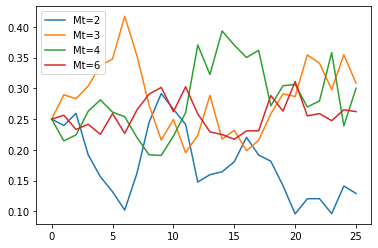

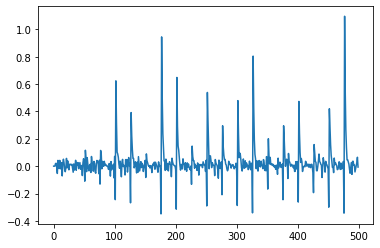

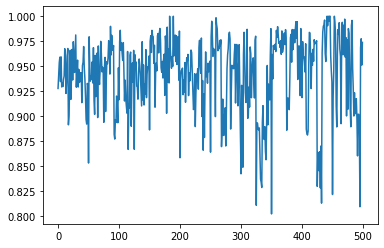

In [60]:
import matplotlib.pyplot as plt



file_specific = '_t_100_ver_' #ファイルにつける特異的な名前
file_name ='/content/drive/My Drive'
N = 12  #要素数
K = 2
G = 4
Mt = 3
I = 1000  # 期数
T = 500  #一期あたりの回数
coord = 1

NK_landscape = np.load(file_name + '/NK_workshop/NK_land_type_1' + '_D_' + str(G) + '_K_' + str(K) + '_i_' + str(I) + '.npy')


var_set = Var_set(N, K, Mt, coord, sigma_head= 0.05, sigma_r=0.05) 
environment = Environment(12, NK_landscape)
agent = Agent(var_set, environment)
manager = Manager(var_set, agent)
rec_Nu_t = []

for i1 in range(int(I/50)):
  for t1 in range(T):
    agent.local_search()
    if t1 % var_set.T_star == 0 :
      manager.select_Mt()
      rec_Nu_t.append(manager.Nu_t)
      # print('select_Mt()されました')
      # print('prob_feasibles:'+str(manager.prob_feasibles))
  # print('rec_norm:' + str(agent.rec_norm))
  print('time_step_t:' + str(t1))
  print('rec_prob_feasibles:')
  print(manager.rec_prob_feasibles)
  environment.step()

  if i1 == 0:
    ave_prob_feasibles = manager.rec_prob_feasibles
  else:
    ave_prob_feasibles = ave_prob_feasibles + manager.rec_prob_feasibles
  print('ave_prob_feasibles\n' + str(ave_prob_feasibles))

  manager.reset()




ave_prob_feasibles = ave_prob_feasibles / int(I/50)
ave_prob_feasibles
ave_prob_feasibles.plot()
plt.legend()
plt.figure()
plt.plot(rec_Nu_t)
rec_norm = agent.rec_norm
sum = 0
rec = []
counter_1 = 0
for t2 in rec_norm:
  counter_1 += 1
  sum += t2
  if counter_1 % 20 == 0:
    rec.append(sum / 20)
    sum = 0

plt.figure()  
plt.plot(rec)



  


In [ ]:
import numpy as np
from os.path import expanduser  # new
import matplotlib.pyplot as plt
import csv
from google.colab import drive
import os
import random

N = 12  #要素数
K = 3
i = 1000  # 期数
t = 100   #一期あたりの回数
coord = 1
file_specific = '_t_100_ver_' #ファイルにつける特異的な名前
file_name ='/content/drive/My Drive'
save_folder_name = '/NK_workshop/Graduation_ver/'

KG_matrix = \
  np.array([
            [2,5,6,7],
            [3,3,4,5],
            [4,2,3,4],
            [6,1,2,3]
            ])
  
Mt_arr = [2,3,4,6]
counter = 1  
result  = [[''] * t +2 for i in range(48)]

for coord in range(3):

  for Mt in Mt_arr:

    for GG in [0,1,2,3]:

      plt.figure(facecolor='white', figsize=(8, 6), dpi=150)

      for KK in [1,2,3]:
        G = KG_matrix[GG,0]
        K = KG_matrix[GG,KK]
        Kex = K - int(N/G) +1

        print('G:'+ str(G))
        print('K:'+ str(K))
        print('Kex:'+ str(Kex)) 
        
        NK_landscape = np.load(file_name + '/NK_workshop/NK_land_type_1' + '_D_' + str(G) + '_K_' + str(K) + '_i_' + str(i) + '.npy')

        var_set = Var_set(N, K, Mt, coord) 
        environment = Environment(12, NK_landscape)
        agent = Agent(var_set, environment)
        rec_norm_all = np.zeros((i,t+1))

        for i1 in range(i):
          for t1 in range(t):
            agent.local_search()
          rec_norm_all[i1, 0:] = agent.rec_norm
          agent = Agent(var_set, environment)
          environment.step()
          

        rec_norm_all_average = []
        for t2 in range(t):
          rec_norm_all_average.append(np.sum(rec_norm_all[0:, t2]) / i)

        result[counter-1][0] = str('_G_' + str(G) + '_K_' + str(K) + '_i_' + str(i)+'_Mt_'+str(var_set.Mt) + '_coord_' + str(var_set.coord))
        result[counter-1][1:] = map(str,rec_norm_all_average)

        x = range(t)
        y = rec_norm_all_average

        label_str = str('G='+str(G) +', K='+ str(K)+ ', Kex=' +str(Kex))
        plt.plot(x,y, label = label_str)
      plt.ylim(0,1)
      if coord == 0:
        coord_str = 'decentralized'
      elif coord == 1:
        coord_str = 'sequential'
      elif coord == 2:
        coord_str = 'proposal'
      plt.title('Transition of normalized contribution ( Mt =' + str(var_set.Mt) + ', coord = ' + str(coord_str) + ')', size=12)
      plt.xlabel('Time Periods', size=12)
      plt.ylabel('Normalized contribution', size=12)
      plt.legend(loc=4,prop={'size':10})
      plt.legend(loc= 'best')
      if not os.path.exists(file_name + save_folder_name):
        os.makedirs(file_name + save_folder_name)
      plt.savefig(file_name + save_folder_name+ '_G_' + str(G) + '_K_' + str(K) + '_i_' + str(i)+'_Mt_'+str(var_set.Mt) + '_coord_' + str(var_set.coord) +str(file_specific)+'.jpg', format='jpg')
      print(str(counter) +  '周目が終わりました')
      counter += 1

      